# Prevendo possíveis resultados e vencendor da copa do mundo de 2022 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import poisson
import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.image as mpimg
import numpy as np
import seaborn as sns
import itertools
from IPython.display import display, HTML

## **Configurações iniciais**

A primeira coisa a se fazer será importar os dados que foram tratados e salvos na etapa de processamento dos dados.

In [2]:
df_partidas_internacionais = pd.read_csv('results_preProcessado.csv') 
df_copa_2022 = pd.read_csv('copa_2022.csv') 
df_times_elo_rating = pd.read_csv('df_times_elo_rating.csv') #dados do elo rating criado a partir dos histórico de partidas internacionais da FIFA para as seleções até 2022
ranking_copa_2022 = pd.read_csv('ranking_copa_2022.csv') 

Note que além dos dois conjuntos de dados inicialmente utilizados na primeira etapa do projeto, agora também foi adicionado outros dois conjuntos de dados que foram criados na etapa anterior, sendo o conjunto de dados a partir do cálculo do elo rating e o conjunto de dados do ranking das seleções da copa de 2022. Todos eles serão úteis para a construção de uma boa análise e entendimento dos dados.

## Exploração e visualização dos dados 

Segundo o esatístico John Tukey, a etapa de exploração de dados ou EDA pode ser definida como:

Procedimentos para analisar dados, técnicas para interpretar os resultados de tais procedimentos, formas de planejar a reunião dos dados para tornar sua análise mais fácil, mais precisa ou mais exata e toda a maquinaria e os resultados da estatística (matemática) que se aplicam a análise de dados.

A exploração de dados ou EDA pode ser considerada uma das fases mais importantes de todo processo de análise de dados. A partir dela começamos a entender mais sobre os dados que envolve a problematica e conseguentemente construir hipoteses e perguntas. Nessa fase, para ajudar no trabalho de entendimento e exploração dos dados é feito o uso de ferramentas estatísticas e de visualização de dados, para que as informações a respeito dos dados sejam a mais clara possivel. Não deve ser levado em consideração um conjunto de regras e passo a passo na hora de construir a análise exploratoria de dados, pelo contrario, a análise exploratória de dados não se trata de um processo formal e sim um estado de espirito investigativo. Na EDA o mais importante é investigar todas as ideias que ocorrerem, conforme o entendimento e significado dos dados vai aumentando.

Pode-se dizer que a EDA é um ciclo iterativo e ciclico, onde:

* É preciso gerar questões relevantes para o negócio, logo, é essencial que em casos reais exista uma conversa com o pessoal da aréa de negocio, a respeito dos dados e oque o pessoal da área de negócio está buscando responder através do conjunto de dados.

* Para encontrar as respostas dos questionamentos levantados é preciso gerar gráficos, manipulação e estatística sobre os dados.

* Refinar os questioanamentos e utiliza-los para gerar novos questionamentos pertinentes.

Um fator essencial que muita das vezes é negligenciado por quem está começando na área dos dados é a estatistica. A estatística tanto univariada como multivariada é de suma importância para os dados ganharem ainda mais significado, durante a exploração de dados.

Para analisar de forma mais específica e objetiva, decidi analisar os dados a partir de dois contextos diferentes, uma análise com base nos dados das partidas internacionais da FIFA e uma análise com base nos dados do ranking da FIFA das seleções, levando também em conta o conjunto de dados do cálculo do elo rating que foi obtido na etapa anterior e o ranking das seleções participantes da copa de 2022.

## Exploração dos dados das partidas internacionais da FIFA até 2022

Agora iniciando a análise dos dados das partidas internacionais, primeiramente vamos entender quais os torneios são mais disputados, tendo em vista que esses dados envolve não só partidas relacionadas ao torneio da copa do mundo.

Vale ressaltar que os dados das partidas internacionais da FIFA vão do ano de 1993 a 2022, mas para ter uma noção e análise melhor do desempenho das seleções nos últimos quatro anos, desde a copa de 2018, irei realizar uma filtragem das partidas internacionais de 2010 a 2022.

In [5]:
df_partidas_internacionais = df_partidas_internacionais[df_partidas_internacionais['date'] >= '2010']

### Quais são os torneios mais disputados (Com mais jogos)?

Text(0.5, 1.0, 'TOP 10 TORNEIOS')

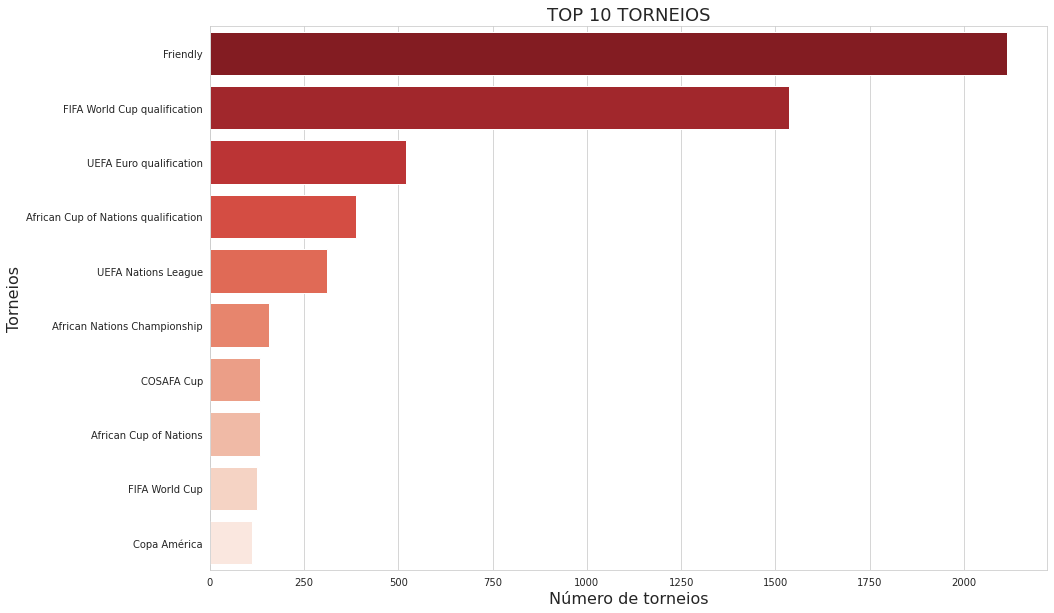

In [6]:
torneios = df_partidas_internacionais['tournament'].value_counts()
torneios = torneios[:10]

plt.figure(figsize = (15,10))
sns.set_style("whitegrid")
ax = sns.barplot(y=torneios.index, x=torneios.values, palette="Reds_r", orient='h')
ax.set_ylabel('Torneios', size=16)
ax.set_xlabel('Número de torneios', size=16)
ax.set_title("TOP 10 TORNEIOS", fontsize=18)

Nota-se que o "torneio" Friendly acaba sendo o que contém mais partidas e o que é mais disputado pelas seleções, mas do que se trata esse torneio? Bem, aqui estamos falando de partidas internacionais e Friendly acaba não se encaixando em nenhum torneio pois trata-se do que conhecemos como partida de amistoso, um jogo de exibição (também conhecido como amistoso, scrimmage, demonstração, jogo de pré-temporada, partida de aquecimento ou partida de preparação, dependendo pelo menos em parte do esporte), e por isso acaba sendo o que as seleções mais acabam disputando. 

O que podemos fazer agora é criar um dataframe com algumas informações estatísticas por seleção como a soma, contagem e média de pontuação para cada equipe, a partir da variável score.

In [7]:
# cria dois dataframes para os times da casa e visitante
home = df_partidas_internacionais[['home_team', 'home_score']].rename(columns={'home_team':'team', 'home_score':'score'})
away = df_partidas_internacionais[['away_team', 'away_score']].rename(columns={'away_team':'team', 'away_score':'score'})

team_score = home.append(away).reset_index(drop=True)


info_paises = team_score.groupby('team')['score'].agg(['sum','count','mean']).reset_index()
info_paises = info_paises.rename(columns={'sum':'nb_goals', 'count':'nb_matches', 'mean':'goal_avg'})

del home, away

Note que foi preciso dividir em dois conjuntos de dados e depois realizar uma agregação com base no score para cada seleção, dessa forma a análise acaba ganhando mais credibilidade estatística.

A partir dos dados agrupados das seleções, pode-se buscar responder algumas perguntas do tipo 

* Quais são as equipes com a melhor média de gols?
* Quais são as equipes que jogaram mais partidas?
* Quais são as equipes que mais pontuaram?

### Quais são as equipes com a melhor média de gols?

Text(0.5, 1.0, 'TOP 10 DA MÉDIA DE GOLS POR JOGO')

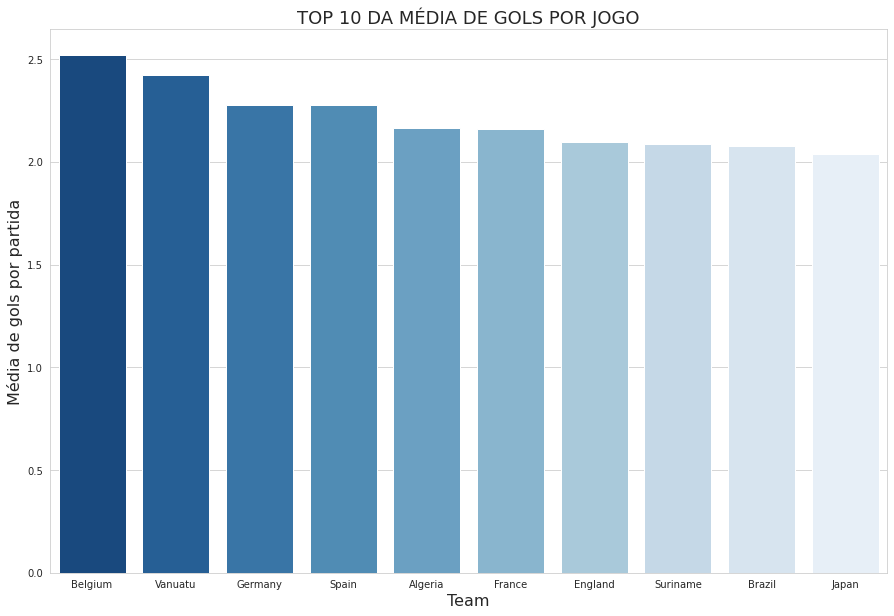

In [8]:
plt.figure(figsize = (15,10))
sns.set_style("whitegrid")
plt_data = info_paises.sort_values(by='goal_avg', ascending=False)[:10]
ax = sns.barplot(x="team", y="goal_avg", data=plt_data, palette="Blues_r")
ax.set_xlabel('Team', size=16)
ax.set_ylabel('Média de gols por partida', size=16)
ax.set_title("TOP 10 DA MÉDIA DE GOLS POR JOGO", fontsize=18)

O interessante do resultado desses gráficos acaba sendo que algumas seleções possuem uma boa média de gols por partidas e não são participantes do torneio da copa do mundo, o que pode ter relação com algumas seleções apenas possuirem uma boa média de gols em partidas de amistosos. 

Outro ponto importante é que Brazil e Alemanha são países que estão bem posicionados no ranking de seleções com base nos dados da FIFA e também possuem uma boa média de gols.

### Quais são as seleções que jogaram mais partidas?

Algo interessante seria entender se os times que possuem melhor média de gols por partidas também são times que jogaram mais partidas, o que nesse caso não acontece. 

Text(0.5, 1.0, 'TOP 10 DO NÚMERO DE PARTIDAS')

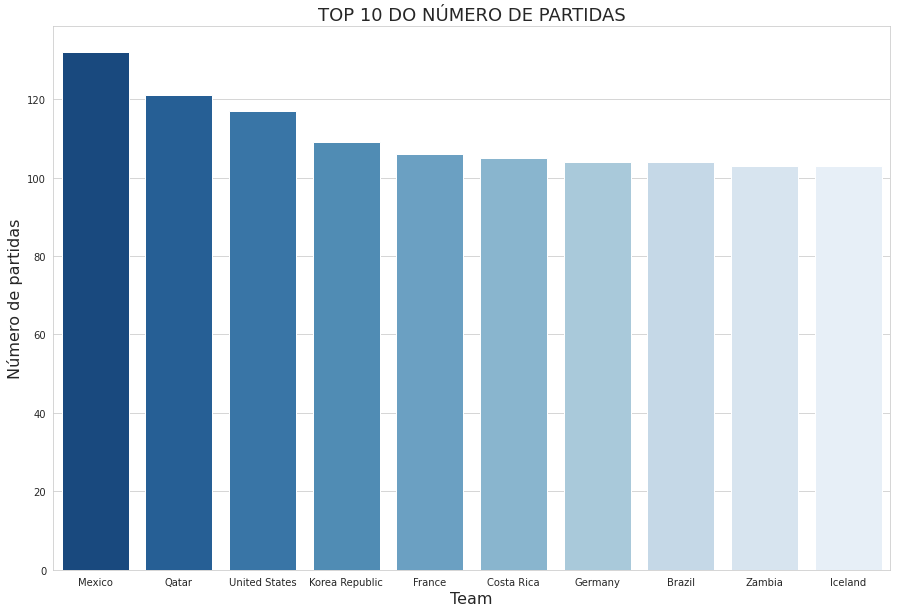

In [9]:
plt.figure(figsize = (15,10))
sns.set_style("whitegrid")
plt_data = info_paises.sort_values(by='nb_matches', ascending=False)[:10]
ax = sns.barplot(x="team", y="nb_matches", data=plt_data, palette="Blues_r")
ax.set_xlabel('Team', size=16)
ax.set_ylabel('Número de partidas', size=16)
ax.set_title("TOP 10 DO NÚMERO DE PARTIDAS", fontsize=18)

Nota-se então que um dos times com maior número de partidas é a seleção do méxico, seleção está que não apareceu no top10 de seleções com melhor média de gols por partidas, então acaba que das seleções que possuem uma boa média de gols por partidas a única que tem um bom número de partidas é a Alemanha, algo positivo tendo em vista que mesmo com um número de partidas maior do que outras seleções, consegue manter uma boa média de gols.

### Quais são as seleções que mais marcaram gols?

Novamente buscando entender a partir de todas as seleções quais que são participantes da copa e se destacam, podemos notar algumas como Japão e França. 

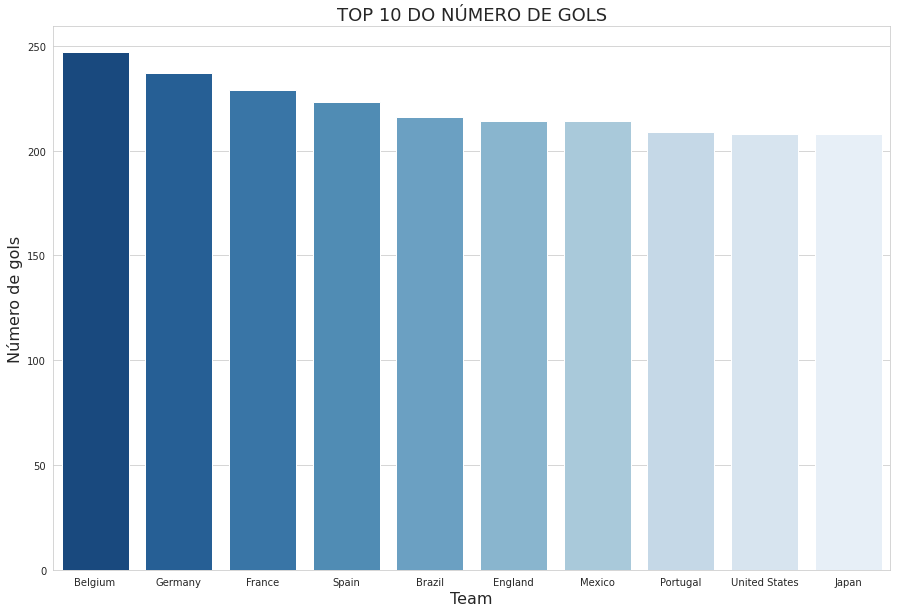

In [10]:
plt.figure(figsize = (15,10))
sns.set_style("whitegrid")
plt_data = info_paises.sort_values(by='nb_goals', ascending=False)[:10]
ax = sns.barplot(x="team", y="nb_goals", data=plt_data, palette="Blues_r")
ax.set_xlabel('Team', size=16)
ax.set_ylabel('Número de gols', size=16)
ax.set_title("TOP 10 DO NÚMERO DE GOLS", fontsize=18)

del plt_data, info_paises

Agora o que irei fazer é entender a partir dos dados da FIFA se em média o time da casa marcou mais gols do que o time visitante, tendo em vista que pela lógica do futebol o time da casa tem um desempenho melhor.

In [11]:
means = df_partidas_internacionais[['home_score','away_score']].mean()
means

home_score    1.547818
away_score    1.050449
dtype: float64

Podemos notar que, em média, o time da casa marcou mais gols do que o time visitante. Então agora é hora de introduzir a distribuição de Poisson: é uma distribuição de probabilidade discreta (fornece as probabilidades de ocorrência de diferentes resultados possíveis em um evento) que expressa a probabilidade de um determinado número de eventos ocorrerem em um intervalo fixo de tempo ou espaço se esses eventos ocorrem com uma taxa constante conhecida e independentemente do tempo desde o último evento (definição da Wikipédia).

Uma suposição importante é que cada evento é independente no tempo. Aqui, significa que os gols não se tornam mais ou menos prováveis pelo número de gols que já são marcados em uma partida. Podemos formular isso pela função de massa de probabilidade:

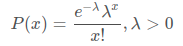

Então, a partir desse entendimento que em média o time da casa marca mais gols, seguindo de acordo com a lógica de partidas do futebol, o que irei fazer agora é verificar se cada equipe segue a distribuição de Poisson devido a partir do número de gols por partida. Entender se os dados seguem a distribuição de Poisson vai ser essencial para construir um modelo linear com base na regressão de Poisson.

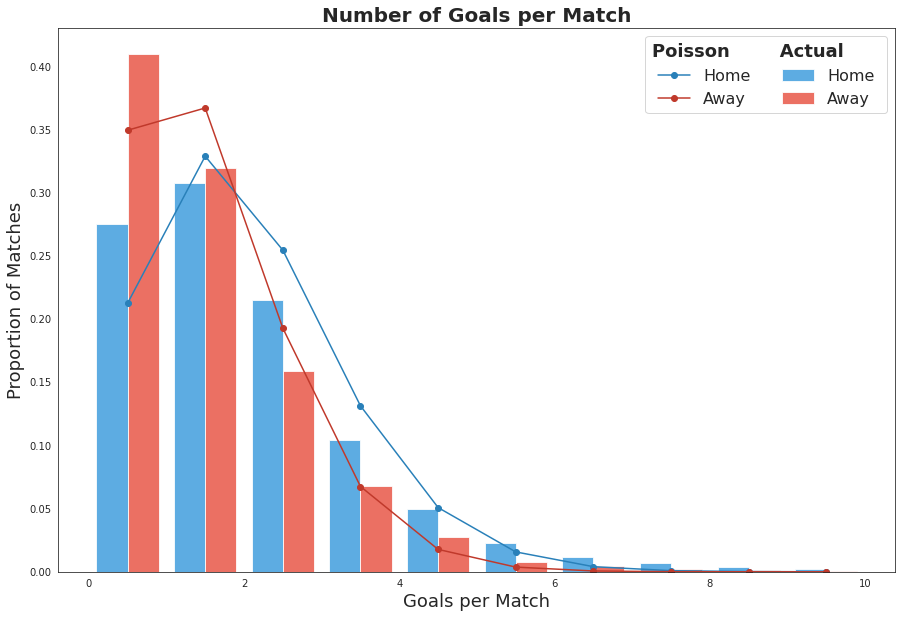

In [12]:
plt.figure(figsize=(15,10))
sns.set_style("white")

poisson_pred = np.column_stack([[poisson.pmf(k, means[j]) for k in range(10)] for j in range(2)]) #constrói Poisson para cada valor médio de metas

plt.hist(df_partidas_internacionais[['home_score', 'away_score']].values, range(11), alpha=0.8,
         label=['Home', 'Away'],density=True, color=["#3498db", "#e74c3c"])


pois1, = plt.plot([i-0.5 for i in range(1,11)], poisson_pred[:,0],
                  linestyle='-', marker='o',label="Home", color = '#2980b9')

pois2, = plt.plot([i-0.5 for i in range(1,11)], poisson_pred[:,1],
                  linestyle='-', marker='o',label="Away", color = '#c0392b')

leg=plt.legend(loc='upper right', fontsize=16, ncol=2)
leg.set_title("Poisson        Actual      ", prop = {'size':'18', 'weight':'bold'})


plt.xlabel("Gols por partidas",size=18)
plt.ylabel("Proporção de partidas",size=18)
plt.title("Número de gols por partida",size=20,fontweight='bold')
plt.show()

Comprovado que a quantidade de gols por partidas segue uma distribuição de poisson. Então, uma boa ideia seria agora construir um Modelo Linear Generalizado com base na regressão de poisson, tendo em vista que a regressão de poisson busca prever um valor de contagem e pode-se através dos dados saber a quantidade de gols por partida, para conseguir chegar no vencendor da partida e as chances de vitória, empate e derrota.

## Exploração dos dados a partir do ranking da FIFA

### Top 10 Times com base no Elo Rating

In [13]:
df_times_elo_rating.sort_values(by=['elo'], ascending=False)[:10]

,team,elo
25,Brazil,2057.941474
8,Argentina,2015.557581
32,Spain,1972.513236
9,Belgium,1962.434181
10,France,1961.708280
1,England,1939.267973
11,Netherlands,1932.733674
15,Germany,1929.178384
40,Portugal,1926.138577
16,Italy,1917.431290


### Grupos mais fortes da copa de acordo com  o ranking da FIFA e Elo Rating

O elo seleçoes é uma base que trata-se do elo rating de cada seleção.

In [14]:
elo_selecoes = df_times_elo_rating.loc[df_times_elo_rating.index.isin(df_copa_2022.index)].sort_values(by=['team'])

ranking_copa_2022['elo_ratings'] = elo_selecoes.loc[:,['elo']] #construindo uma nova variável de elo_rating para cada seleção

ranking_copa_2022 = ranking_copa_2022.merge(df_copa_2022.loc[:,['Grupo']], left_index=True, right_index=True)

ranking_copa_2022.sort_values(by=['Grupo','elo_ratings'],ascending=False)[['Grupo', 'elo_ratings']]

by_group = ranking_copa_2022.groupby('Grupo').std()
by_group['total'] = (by_group['total_points'] / by_group['total_points'].max()) + (by_group['elo_ratings'] / by_group['elo_ratings'].max())
print("Group Competitiveness")
by_group.sort_values(by='total')

Group Competitiveness


,rank,total_points,elo_ratings,total
Grupo,,,,
B,10.148892,67.696935,69.583409,0.764852
H,10.045729,63.615028,115.833362,0.993859
E,10.033278,72.248025,118.344787,1.056698
C,20.122541,152.938008,34.525133,1.058864
D,21.213203,109.987690,105.256234,1.200139
G,7.767453,70.053206,161.028752,1.276998
F,20.436895,109.898773,183.354836,1.625575
A,19.872510,175.676368,150.277733,1.819601


Quais são as seleções do grupo B?

In [15]:
df_copa_2022[df_copa_2022['Grupo']=='B']

,Team,Grupo,Primeiro confronto,Segundo confronto,Terceiro confronto
4,England,B,Iran,United States,Wales
5,Iran,B,England,Wales,United States
6,United States,B,Wales,England,Iran
7,Wales,B,United States,Iran,England


Segundo especialistas os grupos que podem ser considerados mais fortes estão entre o grupo 

* E, que tem Espanha, Costa Rica, Alemanha e Japão; 
* H, com Portugal, Gana, Uruguai e Coreia do Sul; 
* C, que reúne Argentina, Arábia Saudita, México, Polônia 

# Exploração multivariada

Agora o foco está em analisar e identificar as variáveis que inplicaram no valor positivo e também no valor negativo da variável target/principal para o problema, neste caso são as variáveis home_score e away_score que posteriormente irão se tornar uma única váriavel da quantidade de gols. Encontrar essas variáveis é de extrema importância para a construção do modelo de machine learning e descartar as variáveis que não são tão relevantes e apenas estão ocupando memória.

Na análise multivariada, consideramos duas ou mais variáveis simultaneamente, e como elas se relacionam. Então, estamos interessados em verificar como a variação de uma variável influencia as demais e quais seus efeitos conjuntos.

O importante aqui é notar o que influencia as variáveis home_score e away_score, tendo em vista que são as variáveis relacionadas a quantidade de gols em uma partida, essas variáveis são relacionadas ao placar do time da casa e placar do time visitante, respectivamente. O interessante é observar se essas duas variáveis tem impacto em outros variáveis e se consequentemente são úteis para utilizar como target no desenvolvimento do modelo, tendo em vista que os nossos dados seguem uma distribuição de Poisson com base no número de gols.

In [16]:
df_partidas_internacionais_anaMultivariada = df_partidas_internacionais[[
    'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'score_diff', 'result',
       'home_elo', 'away_elo', 'rank_date_home', 'rank_home',
       'country_full_home', 'country_abrv_home', 'total_points_home',
       'rank_date_away', 'rank_away',
       'country_full_away', 'country_abrv_away', 'total_points_away',
        'rank_difference', 'average_rank',
       'point_difference', 'score_difference', 'is_won', 'is_stake',
       'elo_difference', 'wc_participant'
]]

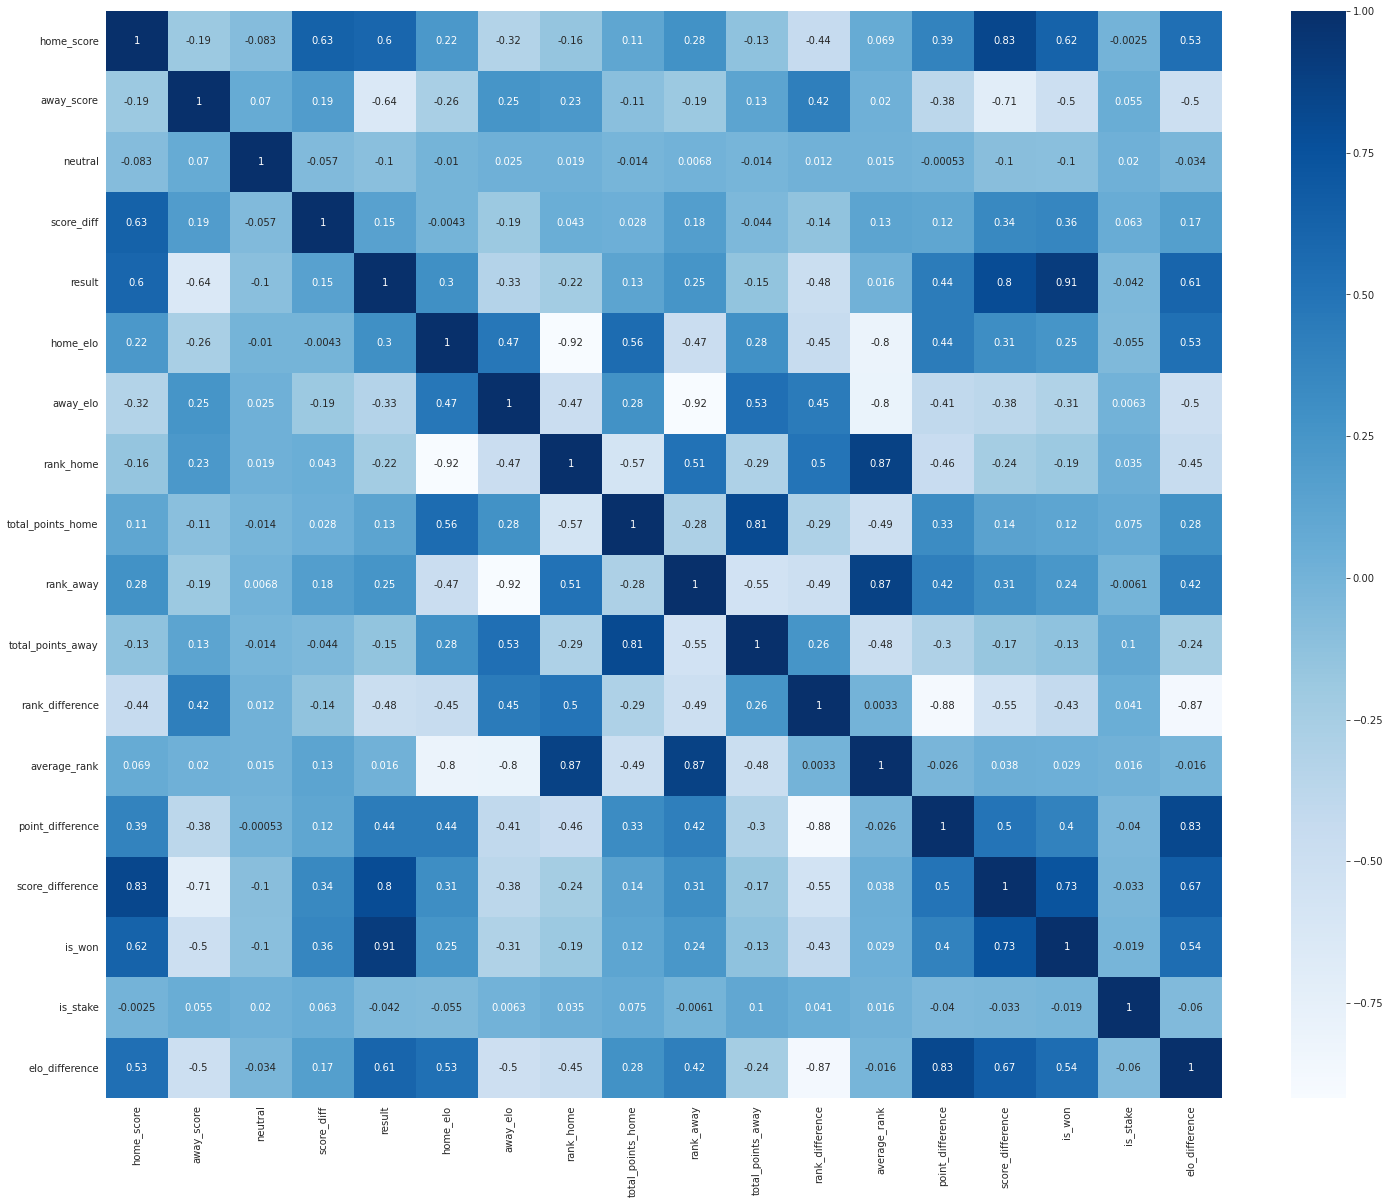

In [17]:
plt.subplots(figsize=(25,20))

sns.heatmap(df_partidas_internacionais_anaMultivariada .corr(),cmap="Blues", annot=True)

plt.show()

Foi possível identificar então que as variáveis com fortes correlações para a variável home_score (placar time da casa) e variável away_score (placar time adversário), acabam sendo:

* score_diff
* result
* home_elo
* away_elo
* rank_home
* rank_away
* total_points_home
* rank_difference
* point_difference
* score_difference
* is_won
* elo_difference

Importante lembrar que algumas foram construídas manualmente a partir dos dados do ranking de seleções da FIFA e cálculo do elo rating.

# Salvando os dados finais

In [19]:
df_partidas_internacionais.to_csv('results_preProcessado.csv',index= False)